In [201]:
import numpy as np
from sklearn.externals import joblib
import pandas as pd
from twitter_package.charts import *
import base64
import warnings
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import plotly.plotly as py
import plotly
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [141]:
classifiers = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    nb = joblib.load('models/nb.pkl')
    classifiers.append(nb)
    log = joblib.load('models/log.pkl')
    classifiers.append(log)
    forest = joblib.load('models/forest.pkl')
    classifiers.append(forest)
    gradboost = joblib.load('models/gradboost.pkl')
    classifiers.append(gradboost)
    adaboost = joblib.load('models/adaboost.pkl')
    classifiers.append(adaboost)
    svm = joblib.load('models/svm.pkl')
    classifiers.append(svm)
    
#load training and test sets
test_data = pd.read_csv('train_test_data/test_data.csv', header=None)
test_data = test_data[1]
train_data = pd.read_csv('train_test_data/train_data.csv', header=None)
train_data = train_data[1]
y_test = pd.read_csv('train_test_data/y_test.csv', header=None)
y_test = y_test[1]
y_train = pd.read_csv('train_test_data/y_train.csv', header=None)
y_train = y_train[1]

def tokenize(tweet):
    tknzr = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
    return tknzr.tokenize(tweet)

tfidfvec2 = TfidfVectorizer(stop_words='english', tokenizer=tokenize, ngram_range=(1,2), max_features=20000)
x_train = tfidfvec2.fit_transform(train_data)
x_test = tfidfvec2.transform(test_data)

In [433]:
def check_model(model_name):
    if model_name=='log':
        return log
    elif model_name=='nb':
        return nb
    elif model_name=='forest':
        return forest
    elif model_name=='gradboost':
        return gradboost
    elif model_name=='adaboost':
        return adaboost
    elif model_name=='svm':
        return svm

def generate_confusion_matrix(input_value):
    model = check_model(input_value)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    cm = confusion_matrix(y_test, predictions)
    print(tp)
    trace = [go.Heatmap(x=['NEG', 'POS'], y=['NEG', 'POS'], z=cm, colorscale='Viridis')]
    return plotly.offline.iplot(trace)

In [434]:
generate_confusion_matrix('log')

497


In [153]:
def generate_classifier_name(model):
    if model==log:
        return 'Logistic Regression'
    elif model==nb:
        return 'Naive Bayes'
    elif model==forest:
        return 'Random Forest'
    elif model==gradboost:
        return "Gradient Boost"
    elif model==adaboost:
        return "Adaboost"
    elif model==svm:
        return 'Support Vector Machine'

def generate_all_roc_curves():
    lw = 2 
    data = []
    for classifier in classifiers:
#         print(classifier)
        classifier_name = generate_classifier_name(classifier)
        classifier.fit(x_test, y_test)
        if classifier==log:
            y_score = classifier.decision_function(x_test)
            fpr, tpr, thresholds = roc_curve(y_test, y_score)
#             print(y_score)
        else:
            y_score = classifier.predict_proba(x_test)
            fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
        roc_auc = auc(fpr, tpr)
        trace = go.Scatter(x=fpr, y=tpr,
                           mode='lines',
#                            line=dict(width=lw, color=color),
                           name='{} (area = {})'.format(classifier_name, round(roc_auc,2)))
        data.append(trace)
    trace = go.Scatter(x=[0, 1], y=[0, 1],
               mode='lines',
               line=dict(width=lw, color='black', dash='dash'),
               name='Luck')
    data.append(trace)
    layout = go.Layout(title='Receiver Operating Characteristic (ROC) Curve',
                       xaxis=dict(title='False Positive Rate', showgrid=False,
                                  range=[-0.05, 1.05]),
                       yaxis=dict(title='True Positive Rate', showgrid=False,
                                  range=[-0.05, 1.05]))
    trace = go.Figure(data=data, layout=layout)
    return plotly.offline.iplot(trace)

In [154]:
generate_all_roc_curves()

In [125]:
def plot_roc_curve(labels, predictions, y_score):
    fpr, tpr, thresholds = roc_curve(labels, y_score)
    print('AUC: {}'.format(auc(fpr, tpr)))
    #Seaborns Beautiful Styling
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [167]:
#import annotated data
df = pd.read_csv('annotated_tweets.csv', engine='python')
df = df.drop('Unnamed: 0', axis=1)

In [168]:
test = df.groupby(['status']).size().reset_index(name='counts')

In [171]:
test.to_csv('annotated_counts.csv')

In [172]:
check = pd.read_csv('annotated_counts.csv')
check

,Unnamed: 0,status,counts
0,0,0,1901
1,1,1,2436


In [158]:
#distribution of annotated dataset (0/1)
yes = df[df['status']==1]
len(yes)

2436

In [159]:
no = df[df['status']==0]
len(no)

1901

In [304]:
data = [
    go.Bar(
        x=['Unrelated', 'Related'], # assign x as the dataframe column 'x'
        y=test['counts'],
        text=['tweets identified as not indicative of a flu infection', 'tweets identified as indicative of a flu infection'],
        marker=dict(color=['rgb(158,202,225)','rgba(204,204,204,1)']),
#         title='Status Distribution of Annotated Tweets'
    )
]
plotly.offline.iplot(data)

In [177]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TweetTokenizer, word_tokenize
from sklearn.feature_selection import chi2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def top_feature_extraction(vectorizer, num_features):
    unrelated_doc_matrix = vectorizer.transform(df[df.status == 0].text)
    related_doc_matrix = vectorizer.transform(df[df.status == 1].text)
    unrelated_tf = np.sum(unrelated_doc_matrix,axis=0)
    related_tf = np.sum(related_doc_matrix,axis=0)
    unrelated = np.squeeze(np.asarray(unrelated_tf))
    related = np.squeeze(np.asarray(related_tf))
    term_freq_df = pd.DataFrame([unrelated,related],columns=vectorizer.get_feature_names()).transpose()
    term_freq_df.columns = ['unrelated', 'related']
    term_freq_df['total'] = term_freq_df['unrelated'] + term_freq_df['related']
    display(term_freq_df.sort_values(by='total', ascending=False).iloc[:num_features])
    return term_freq_df

In [178]:
def plot_most_predictive_features(vectorizer):
    x_train = vectorizer.fit_transform(train_data)
    x_test = vectorizer.transform(test_data)
    chi2score = chi2(x_train, y_train)[0]
    plt.figure(figsize=(15,10))
    wscores = list(zip(vectorizer.get_feature_names(), chi2score))
    wchi2 = sorted(wscores, key=lambda x:x[1])
    topchi2 = list(zip(*wchi2[-20:]))
    x = range(len(topchi2[1]))
    labels = topchi2[0]
    plt.barh(x,topchi2[1], align='center', alpha=0.2)
    plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
    plt.yticks(x, labels)
    plt.xlabel('$\chi^2$')
    plt.title('Most predictive features and associated Chi-square scores')
    
def tokenize(tweet):
    tknzr = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
    return tknzr.tokenize(tweet)

In [179]:
tfidfvec2 = TfidfVectorizer(stop_words='english', tokenizer=tokenize, ngram_range=(1,2))

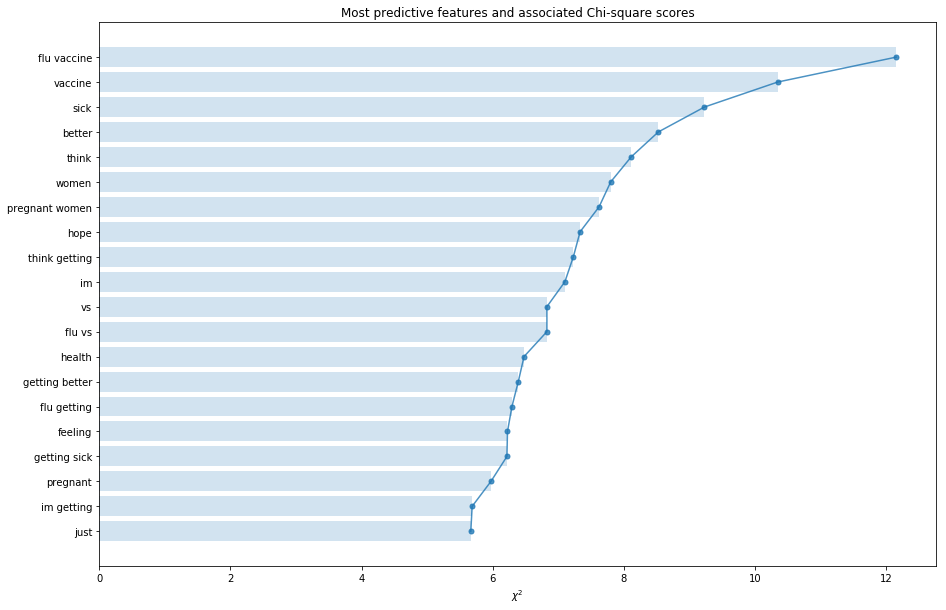

In [181]:
plot_most_predictive_features(tfidfvec2)

In [182]:
top_feature_extraction(tfidfvec2, 20)

,unrelated,related,total
flu,102.734186,129.491639,232.225825
getting,64.871176,118.161319,183.032495
swine,79.190462,84.312682,163.503143
swine flu,78.724501,82.534589,161.259089
getting flu,37.483566,78.709210,116.192775
shot,57.535676,51.426232,108.961908
flu shot,55.281749,48.151779,103.433528
bird,53.299189,40.552192,93.851381
bird flu,51.094601,38.143272,89.237873
getting swine,31.970472,34.612025,66.582497


,unrelated,related,total
aaah,0.000000,0.336562,0.336562
aaah getting,0.000000,0.336562,0.336562
ab,0.363128,0.693575,1.056703
ab getting,0.000000,0.226051,0.226051
ab swine,0.000000,0.276675,0.276675
aban,0.239416,0.000000,0.239416
aban demo,0.239416,0.000000,0.239416
abby,0.000000,0.477694,0.477694
abby docs,0.000000,0.238847,0.238847
abby worried,0.000000,0.238847,0.238847


In [189]:
data = df['text']
labels = df['status']
train_data, test_data, y_train, y_test = train_test_split(data, labels)

x_train = tfidfvec2.fit_transform(train_data)
x_test = tfidfvec2.transform(test_data)
chi2score = chi2(x_train, y_train)[0]
plt.figure(figsize=(15,10))
wscores = list(zip(tfidfvec2.get_feature_names(), chi2score))
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
list(x)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

<Figure size 1080x720 with 0 Axes>

In [196]:
data = [
    go.Bar(
        x=list(topchi2[1]),
        y=list(topchi2[0]), # assign x as the dataframe column 'x'
        orientation='h'
    )
]
plotly.offline.iplot(data)

In [334]:
trace1 = go.Scatter(
    x=list(topchi2[1]),
    y=list(topchi2[0]),
    line = dict(
    color = ('rgb(189,189,189)'),
    width = 2,)
)
trace2 = go.Bar(
        x=list(topchi2[1]),
        y=list(topchi2[0]),
        marker=dict(color=list(range(0,20)),
                   colorscale='Viridis'),
        orientation='h')
data = [trace1, trace2]
plotly.offline.iplot(data)

In [204]:
#import time-series data
def clean_df(df):
    df.reset_index(inplace=True) # Resets the index, makes factor a column
    df.drop('PERCENTAGE OF VISITS FOR INFLUENZA-LIKE-ILLNESS REPORTED BY SENTINEL PROVIDERS',axis=1,inplace=True) # drop factor from axis 1 and make changes permanent by inplace=True
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    df["Date"] = pd.to_datetime(df.WEEK.astype(str)+
                              df.YEAR.astype(str).add('-1') ,format='%W%Y-%w')
    df.set_index(df['Date'], inplace=True)
    df['ILITOTAL'] = df['ILITOTAL'].astype('int64')
    return df

cdc_16 = pd.read_csv('FluViewPhase2Data/16_17.csv')
cdc_17 = pd.read_csv('FluViewPhase2Data/17_18.csv')

cdc_16 = clean_df(cdc_16)
cdc_16 = cdc_16.drop(['AGE 0-4', 'AGE 25-49', 'AGE 25-64', 'AGE 5-24',
               'AGE 50-64', 'AGE 65', 'NUM. OF PROVIDERS', 'YEAR','WEEK',
              '%UNWEIGHTED ILI', 'TOTAL PATIENTS'], axis=1)
cdc_17 = clean_df(cdc_17)
cdc_17 = cdc_17.drop(['REGION TYPE', 'REGION', 'AGE 0-4', 'AGE 25-49', 'AGE 25-64', 'AGE 5-24',
               'AGE 50-64', 'AGE 65', 'NUM. OF PROVIDERS', 'YEAR','WEEK', '% WEIGHTED ILI',
              '%UNWEIGHTED ILI'], axis=1)
cdc_df = pd.concat([cdc_16, cdc_17])

twitter_df = pd.read_csv('Parsed_tweets_2.csv', header=None)
twitter_df.drop([0], axis=1, inplace=True)
twitter_df.columns = ['original_date', 'tweet_id', 'status', 'text', 'week/year']
twitter_df_new = pd.DataFrame(twitter_df['week/year'].str.split('/',1).tolist(),
                                   columns = ['week','year'])
twitter_df = twitter_df.join(twitter_df_new, how='outer')
twitter_df["date"] = pd.to_datetime(twitter_df['week'].astype(str)+
                                           twitter_df['year'].astype(str).add('-1') ,format='%W%Y-%w')
twitter_df = twitter_df.groupby(['date']).size().reset_index(name='count')
twitter_df.set_index(twitter_df['date'], inplace=True)
twitter_df['count'] = twitter_df['count'].astype('int64')
# twitter_df = twitter_df.drop(['date'], axis=1)
twitter_df = twitter_df['2016-10-03':'2018-09-10']

fin_cdc_df = cdc_df.join(twitter_df, how='outer')
fin_cdc_df.at['2018-07-30', 'count'] = 7107
fin_cdc_df.at['2018-08-06', 'count'] = 7107

In [206]:
twitter_df.head()

,date,count
date,,
2016-10-03,2016-10-03,35133
2016-10-10,2016-10-10,34220
2016-10-17,2016-10-17,33086
2016-10-24,2016-10-24,33267
2016-10-31,2016-10-31,25675


In [413]:
trace1 = go.Scatter(x=cdc_df['Date'], y=cdc_df['ILITOTAL'],
                       line = dict(
                            color = '#7A69C7',
                            width = 2,))
trace2 = go.Scatter(x=twitter_df['date'], y=twitter_df['count'],
                            line = dict(
                            color = '#C76977',
                            width = 2,))
data = [trace1, trace2]
plotly.offline.iplot(data)

In [215]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

cdc_df_new = cdc_df.drop(['Date'], axis=1)
moving_avg = cdc_df_new.rolling(12).mean()
moving_std = cdc_df_new.rolling(12).std()

trace1 = go.Scatter(x=cdc_df['Date'], y=cdc_df['ILITOTAL'])
trace2 = go.Scatter(x=cdc_df['Date'], y=moving_avg['ILITOTAL'])
trace3 = go.Scatter(x=cdc_df['Date'], y=moving_std['ILITOTAL'])


data = [trace1, trace2, trace3]
plotly.offline.iplot(data)

# orig = plt.plot(df, color='blue',label='Original')
# mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
# std = plt.plot(moving_std, color='black', label = 'Rolling Std')
# plt.legend(loc='best')
# plt.title('Rolling Mean & Standard Deviation')
# plt.show(block=False)

# print ('Results of Dickey-Fuller Test:')
# dftest = adfuller(count, autolag='AIC')

# # Extract and display test results in a user friendly manner
# dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
# for key,value in dftest[4].items():
#     dfoutput['Critical Value (%s)'%key] = value
# print (dfoutput)

In [217]:
(adfuller(cdc_df_new['ILITOTAL'], autolag='AIC'))[1]

0.05233197484315127

In [228]:
def generate_classifier_name(model):
    if model==log:
        return 'Logistic Regression'
    elif model==nb:
        return 'Naive Bayes'
    elif model==forest:
        return 'Random Forest'
    elif model==gradboost:
        return "Gradient Boost"
    elif model==adaboost:
        return "Adaboost"
    elif model==svm:
        return 'Support Vector Machine'
    
def generate_roc_curve(input_value):
    data = []
    lw=2
    model = check_model(input_value)
    model.fit(x_train, y_train)
    model_name = generate_classifier_name(model)
    if model==log:
        y_score = model.decision_function(x_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
    else:
        y_score = model.predict_proba(x_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
    roc_auc = auc(fpr, tpr)
    trace = go.Scatter(x=fpr, y=tpr,
                       mode='lines',
                           line=dict(width=lw, color='b'),
                       name='{} (area = {})'.format(model_name, round(roc_auc,2)))
    data.append(trace)
    trace = go.Scatter(x=[0, 1], y=[0, 1],
               mode='lines',
               line=dict(width=lw, color='black', dash='dash'),
               name='Luck')
    data.append(trace)
    layout = go.Layout(title='Receiver Operating Characteristic (ROC) Curve',
                       xaxis=dict(title='False Positive Rate', showgrid=False,
                                  range=[-0.05, 1.05]),
                       yaxis=dict(title='True Positive Rate', showgrid=False,
                                  range=[-0.05, 1.05]))
    fig = go.Figure(data=data, layout=layout)
    return plotly.offline.iplot(fig)

In [229]:
generate_roc_curve('log')

## 3D plots for Doc2Vec

In [261]:
#import annotated data
df = pd.read_csv('annotated_tweets.csv', engine='python')
df = df.drop('Unnamed: 0', axis=1)

In [262]:
df.head()

,created_at,id,user_id,user_location,status,text
0,Wed Oct 28 11:36:12 +0000 2009,5228025912,29536454,"Acworth, GA",0,is not afraid if swine flu swine flu is afraid...
1,Sat Nov 21 11:28:07 +0000 2009,5916627706,85937238,NaN,0,reported human cases of bird flu or influenza
2,Mon Nov 23 22:09:26 +0000 2009,5989190910,24870223,"London, UK",0,rt review the things that keep us here carla b...
3,Wed Oct 28 13:49:53 +0000 2009,5230454602,19621888,"Livingston, West Lothian",1,just finished getting on my high horse about a...
4,Wed Oct 28 06:56:27 +0000 2009,5224474202,36680785,"San Diego, CA",0,anxious crowds meet ad hoc swine flu police


In [265]:
# Create TaggedDocument objects for train_corpus
train_corpus = []
for i in range(0, len(df)):
    doc = TaggedDocument(df['text'][i].split(), [df['status'][i]])  
    train_corpus.append(doc)
train_corpus[0]

TaggedDocument(words=['is', 'not', 'afraid', 'if', 'swine', 'flu', 'swine', 'flu', 'is', 'afraid', 'of', 'me'], tags=[0])

In [267]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from tqdm import tqdm

cores = multiprocessing.cpu_count()

#the doc2vec training is completely unsupervised and thus there is no need to hold out any data, as it is unlabelled. 
#labelise each tweet with unique IDs using Gensim’s LabeledSentence function.
def labelize_tweets(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result
  
model = Doc2Vec(dm=0, vector_size=100, negative=5, min_count=0, workers=cores, alpha=0.065, min_alpha=0.065)
model.build_vocab(train_corpus)

doc_vectors = [model.infer_vector(train_corpus[i].words) for i in range(0,len(train_corpus))]

In [269]:
# reduce dimensionality to visualize the document vectors 
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(doc_vectors)
doc_vectors_3d = pca.transform(doc_vectors) # transform the vectors to 3d space
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)[2]
print('Explained variance ratio is {:.2f}%, {:.2f}% is lost by reducing the dimensionality'.format((explained_variance_ratio*100), (100-(explained_variance_ratio*100)))) 

Explained variance ratio is 3.82%, 96.18% is lost by reducing the dimensionality


In [270]:
# Dataframes for plotting
doc_vectors_3d = pd.DataFrame(doc_vectors_3d)  

# create status dictionaries for mapping 
status = list(set((df['status'])))
num = list(range(0,len(status)))
status_num = dict(zip(status, num))

# by author
status_df = pd.DataFrame([train_corpus[i].tags[0] for i in range(0, len(train_corpus))])
doc_vectors_3d_with_status =pd.concat([doc_vectors_3d,status_df], axis = 1)
doc_vectors_3d_with_status.columns = ['x','y','z','status']
doc_vectors_3d_with_status['status'] = doc_vectors_3d_with_status['status'].map(status_num)

In [350]:
def status_name(status):
    if status==0:
        return 'Unrelated'
    elif status==1:
        return 'Related'

def status_color(status):
    if status==0:
        return 'blue'
    elif status==1:
        return 'purple'

In [353]:
def doc2vec_plot():
    traces_for_plot = []
    for key, value in status_num.items():
        df = doc_vectors_3d_with_status[doc_vectors_3d_with_status['status'] == value]
        traces_for_plot.append(df)

    traces_status = []
    for trace in traces_for_plot:
        trace1 = go.Scatter3d(
        x = trace['x'],
        y = trace['y'],
        z = trace['z'],
        mode='markers',
        name = status_name(status[trace['status'].values[0]]),
        marker=dict(
            size=5,
            color=status_color(status[trace['status'].values[0]]),
            opacity=0.5
        )
        )
        traces_status.append(trace1)

    layout = go.Layout(showlegend=True)
    # # Make a figure object
    fig = go.Figure(data= traces_status, layout = layout)
    return plotly.offline.iplot(fig)

In [354]:
doc2vec_plot()

In [277]:
#load training and test sets
test_data = pd.read_csv('train_test_data/test_data.csv', header=None)
test_data = test_data[1]
train_data = pd.read_csv('train_test_data/train_data.csv', header=None)
train_data = train_data[1]
y_test = pd.read_csv('train_test_data/y_test.csv', header=None)
y_test = y_test[1]
y_train = pd.read_csv('train_test_data/y_train.csv', header=None)
y_train = y_train[1]

In [291]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

def labelize_tweets(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result
  
all_x = df['text']
all_x_w2v = labelize_tweets(all_x, 'all')

def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs

model_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=0, workers=cores, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_x_w2v)])

train_vecs = get_vectors(model_dbow, train_data, 100)
validation_vecs = get_vectors(model_dbow, test_data, 100)

/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:570: UserWarning:

The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.

100%|██████████| 4337/4337 [00:00<00:00, 1206759.75it/s]


In [357]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
d2v_std = scaler.fit_transform(train_vecs)
d2v_std_val = scaler.fit_transform(validation_vecs)
d2v_pca = PCA().fit(d2v_std)
x_values = list(range(1, d2v_pca.n_components_+1))
trace1 = go.Scatter(x=x_values, y=d2v_pca.explained_variance_ratio_, name='explained variance',
                       line = dict(
                                    color = '#900C3F',
                                    width = 2,))
trace2 = go.Scatter(x=x_values, y=np.cumsum(d2v_pca.explained_variance_ratio_), name='cumulative explained variance',
                    line = dict(
                    color = '#6973C7',
                    width = 2,))
data = [trace1, trace2]
plotly.offline.iplot(data)

In [305]:
count_df = pd.read_csv('count_metrics.csv')
count_df = count_df.drop('Unnamed: 0', axis=1)
tfidf_df = pd.read_csv('tfidf_metrics.csv')
tfidf_df = tfidf_df.drop('Unnamed: 0', axis=1)
doc2vec_df = pd.read_csv('doc2vec_metrics.csv')
doc2vec_df.rename(columns={'Unnamed: 0': 'Training Method (n-gram)'}, inplace=True)

In [312]:
doc2vec_df

,Training Method (n-gram),Validation Accuracy
0,DBOW (Unigram),73.824885
1,DMC (Unigram),61.658986
2,DMM (Unigram),70.322581
3,DBOW-DMC (Unigram),74.470046
4,DBOW-DMM (Unigram),73.640553
5,DBOW (Bigram),73.917051
6,DMC (Bigram),61.658986
7,DMM (Bigram),70.691244
8,DBOW-DMC (Bigram),73.271889
9,DBOW-DMM (Bigram),71.981567


In [313]:
count_df['Count (Unigram)'] = count_df['Count (Unigram)'].map(lambda x: round(x, 1))
count_df['Count (Bigram)'] = count_df['Count (Bigram)'].map(lambda x: round(x, 1))
count_df['Count (Trigram)'] = count_df['Count (Trigram)'].map(lambda x: round(x, 1))
tfidf_df['TF-IDF (Unigram)'] = tfidf_df['TF-IDF (Unigram)'].map(lambda x: round(x, 1))
tfidf_df['TF-IDF (Bigram)'] = tfidf_df['TF-IDF (Bigram)'].map(lambda x: round(x, 1))
tfidf_df['TF-IDF (Trigram)'] = tfidf_df['TF-IDF (Trigram)'].map(lambda x: round(x, 1))
doc2vec_df['Validation Accuracy'] = doc2vec_df['Validation Accuracy'].map(lambda x: round(x, 1))

In [315]:
count_df.drop(['Count (Unigram) Round'], axis=1, inplace=True)

In [319]:
count_df.to_csv('count_metrics.csv')
tfidf_df.to_csv('tfidf_metrics.csv')
doc2vec_df.to_csv('doc2vec_metrics.csv')

In [416]:
test = df[['text', 'status']]
test.head(2000)

,text,status
0,is not afraid if swine flu swine flu is afraid...,0
1,reported human cases of bird flu or influenza,0
2,rt review the things that keep us here carla b...,0
3,just finished getting on my high horse about a...,1
4,anxious crowds meet ad hoc swine flu police,0
5,getting ready for magda flu jab in cester appa...,0
6,swine flu on fav sources like gawker swine flu...,0
7,anxious crowds meet ad hoc swine flu police ef...,0
8,from times transcr who getting flu shots is so...,0
9,swineflu anxious crowds meet ad hoc swine flu ...,0
